<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/11_talkingData_CatFeature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 25th July, 2021
# Myfolder: C:\Users\Administrator\OneDrive\Documents\talkingdata
# Ref: https://www.kaggle.com/nanomathias/feature-engineering-importance-testing
#      https://www.kaggle.com/nuhsikander/lgbm-new-features-corrected
#      https://github.com/harnalashok/h2o
#
# Data source: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection
# Objectives:
#           i)    Categorical feature engineering
#                 using aggregation

## About the Problem

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest
mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Data fields

Each row of the training data contains a click record, with the following features.

    ip: ip address of click.
    app: app id for marketing.
    device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
    os: os version id of user mobile phone
    channel: channel id of mobile ad publisher
    click_time: timestamp of click (UTC)
    attributed_time: if user download the app for after clicking an ad, this is the time of the app download
    is_attributed: the target that is to be predicted, indicating the app was downloaded


##How to create new features from categorical features

>Categorical features can be encoded either using OneHotEncoding technique or using Hashing technique. But if the categorical features have bery large number of levels, then in both cases very large number of features will be generated.  
Another option is to develop new features by transforming each cat-feature to one numeric column. There can be many ways to do this and, therefore, one cat-feature can get transformed to many numeric features. But, when we do this, we have a control over how many numeric columns we create and can also examine which are more important. This example demonstartes feature creation using this option. 

##Mounting Google Drive and calling libraries

In [1]:
# 1.0 Mount your google drive 
#      so that you can access data files 
#      on your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# 1.1 Call libraries
# %reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, gc
import os,time

In [3]:
# 1.2 Display output from multiple commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# 1.3 Change folder to where TalkingData is:
#os.chdir("C:\\Users\\Administrator\\OneDrive\\Documents\\talkingdata")
path =  "/content/drive/MyDrive/Colab_data_files/talkingData/"
os.listdir(path)

['train.csv', 'test.csv.zip', 'train.csv.zip', 'talkingData_sample.csv.zip']

## Feature Engineering
Should feature extraction be from train only or from train+test

>    "*As Andy once said in the comment of a kernel(Sorry, i can't remember which kernel since i have try more than 20 until now): There is nothing to stop us from doing that. I think that makes sense because when we generate some new features using frequency,mean,var,count,unique etc. , we want to get the accurate numerical number as much as we can which is close to the hidden population distribution statistically in this 4 days , test set is also a sample of this population distribution in this 4 days, So we NEED to use train/test set together to generate the statistical features which can help us get close to the hidden population distribution. And as you can imagine, If we can use the entire train/test set to compute the features, that certainly would be more accurate to train our model.*"

>    "*A perfect algorithm might not need these features. But no algorithm is perfect so you can think of derived features as aiding/helping the classifier figure out what might be relevant to classify correctly.*"


##Read full Data
Read either full data or sample data

In [ ]:
# 2.0 From our experience of earlier reading of data
#      we know that data types of some of the features.
#       We use those data-types leading to almost half 
#        of memory-usage

%%time

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('load train...')


# 2.2.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header
train = pd.read_csv(
                     path + "train.csv.zip",  # Not reading test.csv.zip
                     header=0,  # First row is header-row
                                # 'and' operator returns True if both values are True
                                #  random.random() returns values between (0,1)
                                #  No of rows skipped will be around 60% of total
                      dtype=dtypes,
                      # We read all columns. Here are the column-names
                      #  in the sequence they occur in the train data
                      usecols=['ip','app','device','os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
                    )


In [8]:
# 2.2.2
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [11]:
# 2.3 Unique values in a few features
f"Unique ips  {train['ip'].nunique()}"
print()
f"Unique os  {train['os'].nunique()}"
print()
f"Unique device  {train['device'].nunique()}"
print()
f"Unique channel  {train['channel'].nunique()}"

'Unique ips  277396'

'Unique os  800'

'Unique device  3475'

'Unique channel  202'

### OR, Read a sample of it
We read here directly from the original training data file. As data is large, we sample it.

To read this data and save memory, please see this [kernel](https://www.kaggle.com/nuhsikander/lgbm-new-features-corrected)

In [21]:
# 3.0 From our experience of earlier reading of data
#      we know that data types of some of the features.
#       We use those data-types leading to almost half 
#        of memory-usage

%%time

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('load train...')


# 3.1 Read a fraction of data
total_lines = 184903891 # 18,49,03,891
read_lines = 400000    # (4 lakh) Reduce it if less RAM

# 3.2 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

# 3.2.1 How to pick up random rows from hard-disk
#       without first loading the complete file in RAM
#       Toss a coin:
#           At each row, toss a biased-coin: 60%->Head, 40%->tail
#           If tail comes, select the row else not.
#           Toss a coin: random.random()
#           Head occurs if value > 0.6 else it is tail
#
#       We do not toss the coin for header row. Keep the header
train = pd.read_csv(
                     path + "train.csv.zip",  # Not reading test.csv.zip
                     header=0,  # First row is header-row
                                # 'and' operator returns True if both values are True
                                #  random.random() returns values between (0,1)
                                #  No of rows skipped will be around 60% of total
                      skiprows=lambda i: (i >0 ) and (np.random.random() > p),    # (i>0) implies skip first header row
                      dtype=dtypes,
                      # We read all columns. Here are the column-names
                      #  in the sequence they occur in the train data
                      usecols=['ip','app','device','os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
                    )


load train...
CPU times: user 3min 17s, sys: 1.76 s, total: 3min 19s
Wall time: 3min 19s


In [37]:
# 3.3 Store sampled data to a file on 
#         Google drive for later use
pathToSave = path  
filePath = pathToSave + "talkingData_sample.csv.zip"

# 3.4 But first delete existing file.
#        The following will NOT work.
#          python variables are not available in shell
# ! rm -f filePath

# 3.5 This will work:
os.remove(filePath)

# 3.6 Check if deleted
os.listdir(pathToSave)
#! rm -f /root/talkingData_sample.csv.zip

['train.csv', 'test.csv.zip', 'train.csv.zip']

In [27]:
# 3.7 Save the sample data into VM only
start = time.time()
train.to_csv(filePath, compression = "zip", index = False)
end = time.time()
(end-start)/60     # 3 minutes

0.030960341294606526

In [28]:
# 3.8 Check saved file 
#       and get size of saved file 
  
os.stat(filePath).st_size/1000000.0  # (305 MB)

3.612058

## Else, read sampled saved data
Read already saved sampled data from Google drive

In [5]:
# 4.0 Path to saved sample data in Google Drive
pathToSavedData = "/content/drive/MyDrive/Colab_data_files/talkingData/" + "talkingData_sample.csv.zip"

%%time

# 4.1 Our dtypes
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }



# 4.2 Read the sample file
train = pd.read_csv(
                     pathToSavedData,
                     dtype = dtypes,
                     header=0,  # First row is header-row
                    )

train.dtypes

0.006573828061421713

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

In [6]:
# 4.3
train.dtypes
train.memory_usage().sum()
gc.collect()

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

11586208

99

#### Which features are of which type
Here is how the features are being treated:  
Target feature is '*is_atributed*'  

<table>
<tr>
    <th>ip</th>
    <th>app</th>
    <th>os</th> 
    <th>channel</th>
    <th>day</th>
    <th>hour</th> 
    <th>is_attributed</th>
</tr>
<tr>
    <td>categorical</td> 
    <td>categorical</td> 
    <td>categorical</td>
    <td>categorical</td> 
    <td>numeric/categorical</td> 
    <td>numeric/categorical</td>
    <td>categorical</td>
</tr>
</table>
-----------------------------------------------------------<br><br>


#### How feature engineering has been performed?<br>



A. <u>Relationship of categorical features with target</u>:

> We develop probabilistic relationship between feature levels and the target values. For some feature, if everytime a level, say, x, occurs and the target is 1, we have an ideal relationship between that *level x* and the target; on the other hand if every time a level, say, y, occurs and target value is 0, we have the worst possible relationship.<br>   Essentially, given a level, x, we are calculating probability of target being 1. 
Suppose a level, x, occurs 'g1' times and in these 'g1' times, the target, value of 1 occurs g2 times. <br>Then:

> `prob(target =1/level =x) = g2/g1`

> However, to have confidence in this probability, we should be having sufficiently large number of instances of x ie g1 should be a sufficiently large number, statistically.

> For this reason, we moderate the calculated probabilities by a factor known as `confRate`. More will be the confidence in the probability if more the evidence or more the occurrences of a particular level (in a catgorical feature) among all levels.<br>

> For example, let a categorical feature contain three levels: level-1, level-2 and level-3. Let level-1, occur in 6 rows, level-2 occur in 5-rows but level-3 occur just in 1 row. Let `np.sum(target)` for level-1 be 2 and `np.sum(target)` for level-2 be 5. Then group probability will be as shown below. But confidence in probability calculations related to level-3 feature would be very low as its probability calculations are based on just one ocurrence of level-3.<br>

> Here is an example of how we calculate probabilities:<br><br>
`grouped = df.groupby(df['x'])`<br>
        `prob = grouped['target'].sum()/ grouped['target'].count()`<br>
        `confRate = np.log(grouped.count())/np.log(constant)` <br><br>

> Briefly, beyond certain number of occurrences of level-x, we want to flatten the importance or confRate. Below is the graph of `np.log(count)`:


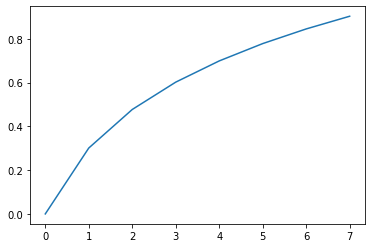

In [7]:
# 4.4 After count has reached a level,
# log(count) saturates
y = np.log10(np.arange(1,9))
plt.plot(y);

> To determine appropriate values for `log(constant)`, may be a graph can be drawn between `confRate` and `log(constant)`, or `probability X confRate` vs `log(constant)` and then take a decision. In fact `log(constant)` can also be treated as a *hyperparameter*.  <br><br>
**Data Leakage**<br>
There is a word of caution here. Such probability calculations may result in *Data Leakage* or leaking target information into new features. But if data is very large, the derived numerical feature may actually reflect the statistics it is intended to calculate. 

>Table 1

<table>
<tr>
    <th>cat_feature</th>
    <th>target</th>
    <th>gr. prob</th>
    <th>Conf-level</th> 
</tr>
<tr>
    <td>level-1</th>
    <td>1</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-2</th>
    <td>0</td>
    <td>3/5</td>
    <td>high</td> 
</tr>
<tr>
    <td>level-1</th>
    <td>0</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-1</td>
    <td>0</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-2</td>
    <td>1</td>
    <td>3/5</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-1</td>
    <td>0</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-2</td>
    <td>1</td>
    <td>3/5</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-2</td>
    <td>0</td>
    <td>3/5</td>
    <td>high</td> 
</tr>
<tr>
    <td>level-2</td>
    <td>1</td>
    <td>3/5</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-1</td>
    <td>0</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-1</td>
    <td>1</td>
    <td>2/6</td> 
    <td>high</td>
</tr>
<tr>
    <td>level-3</td>
    <td>1</td>
    <td>1/1</td>
    <td>**LOW**</td> 
</tr>
</table>

Here is a list of features on which we perform above operations:

>Table 2

sno|grouping-feature|
-|-|
1|ip|
2|app|
3|os|
4|channel|
5|app+channel|
6|app+os|
7|app+device|
8|channel+os|
9|channel+device|
10|os+device|


B. <u>Relationship of categorical features among themselves</u>:

There is a possibility to create a huge number of features. These features naturally take very large RAM.  
>Table 3
<table>
<tr>
    <th>Sno</th>
    <th>GroupBy</th>
    <th>Operation</th>
    <th>On</th> 
    <th>Remarks</th>
</tr>
<tr>
    <td>1</td>
    <td>IP</td> 
    <td>nunique</td> 
    <td>channel</td>
    <td>Per IP, how many unique channels</td> 
</tr>
<tr>
    <td>2</td>
    <td>IP</td> 
    <td>nunique</td> 
    <td>app</td>
    <td>Per IP, how many unique app</td> 
</tr>
<tr>
    <td>3</td>
    <td>IP</td> 
    <td>nunique</td> 
    <td>device</td>
    <td>Per IP, how many unique device</td> 
</tr>
<tr>
    <td>4</td>
    <td>IP</td> 
    <td>nunique</td> 
    <td>os</td>
    <td>Per IP, how many unique os</td> 
</tr>
<tr>
    <td>5</td>
    <td>IP</td> 
    <td>cumcount</td> 
    <td>app</td>
    <td>Per IP, cumcount of app</td> 
</tr>
<tr>
    <td>6</td>
    <td>IP</td> 
    <td>cumcount</td> 
    <td>os</td>
    <td>Per IP, cumcount of os</td> 
</tr>
<tr>
    <td>7</td>
    <td>IP</td> 
    <td>count</td> 
    <td>channel</td>
    <td>Per IP, count of channel</td> 
</tr>
<tr>
    <td>8</td>
    <td>app</td> 
    <td>count</td> 
    <td>channel</td>
    <td>Per app, count of channel</td> 
</tr>
<tr>
    <td>9</td>
    <td>channel</td> 
    <td>count</td> 
    <td>app</td>
    <td>Per channel, count of app</td> 
</tr>
<tr>
    <td>10</td>
    <td>ip+app</td> 
    <td>count</td> 
    <td>channels</td>
    <td>Per ip+app, count of channels</td> 
</tr>
<tr>
    <td>11</td>
    <td>ip+app</td> 
    <td>nunique</td> 
    <td>os</td>
    <td>Per ip+app, how many unique os</td> 
</tr>
<tr>
    <td>12</td>
    <td>ip+day</td> 
    <td>nunique</td> 
    <td>hours</td>
    <td>Per ip+day how many unique hours</td> 
</tr>
<tr>
    <td>13</td>
    <td>ip+day+channel</td> 
    <td>variance</td> 
    <td>hour</td>
    <td>Per ip+day+channel variance of hour</td> 
</tr>
<tr>
    <td>14</td>
    <td>ip+day+channel</td> 
    <td>mean</td> 
    <td>hour</td>
    <td>Per ip+day+channel mean of hour</td> 
</tr>
<tr>
    <td>15</td>
    <td>ip+app+os</td> 
    <td>variance</td> 
    <td>hour</td>
    <td>Per ip+app+os variance of hour</td> 
</tr>
<tr>
    <td>16</td>
    <td>ip+app+os</td> 
    <td>count</td> 
    <td>channels</td>
    <td>Per ip+app+os count of channel</td> 
</tr>
<tr>
    <td>17</td>
    <td>ip+app+channel</td> 
    <td>variance</td> 
    <td>hour</td>
    <td>Per ip+app+channel variance of hours</td> 
</tr>
<tr>
    <td>18</td>
    <td>ip+device+os</td> 
    <td>cumcount</td> 
    <td>app</td>
    <td>Per ip+device+os cumcount of app</td> 
</tr>
<tr>
    <td>19</td>
    <td>ip+device+os</td> 
    <td>nunique</td> 
    <td>os</td>
    <td>Per ip+device+os how many unique of app</td> 
</tr>
<tr>
    <td>20</td>
    <td>ip+day+channel</td> 
    <td>variance</td> 
    <td>hour</td>
    <td>Per ip+day+channel variance of hour</td> 
</tr>
<tr>
    <td>21</td>
    <td>ip+day+hour</td> 
    <td>count</td> 
    <td>channel</td>
    <td>Per ip+day+hour count of channel</td> 
</tr>
<tr>
    <td>22</td>
    <td>ip+app+day+hour</td> 
    <td>count</td> 
    <td>channel</td>
    <td>Per ip+app+day+hour variance of hour</td> 
</tr>
</table>
-----------------------------------------------------------<br>


##Explore data

In [ ]:
# 5.0
print(train.shape)   # (999189, 8)
print()
train.head(3)

# 5.1
print("---dtypes----")
print(train.dtypes) # ip int64,app int64,device int64,os int64,channel int64,
                    # click_time object,attributed_time object,is_attributed int64

# 5.2 Let us see distribution of NULLS
print("---Nulls----")
print(train.isnull().sum())      # 299084 nulls in attributed_time

# 5.3 Transform 'click_time' to datetime
train['click_time'] = pd.to_datetime(train['click_time'])

In [9]:
# 5.4 Derive some date components
train['day']    = train['click_time'].dt.day.astype('uint8')
train['hour']   = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')
train.head(3)
train.shape   # (999280, 12)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,191894,3,1,18,379,2017-11-06 15:29:16,NaN,0,6,15,29,16
1,22333,3,1,19,379,2017-11-06 15:48:50,NaN,0,6,15,48,50
2,124769,3,1,25,402,2017-11-06 16:00:01,NaN,0,6,16,0,1


(399520, 12)

## My experiments

In [10]:
# 6.0 A list of lists
#      Group by each one of the sub-lists
#       and calculate probabilities of the target
#        being 1
myplan = [
          ['ip'], ['app'],
          ['ip', 'app'],['ip','device'],
          ['app', 'device','channel']
         ] 

In [55]:
# 6.1 Define function to calculate confidence

# 6.1.1
const = np.log(100000)

# 6.1.2
def rate_calculation(cnt, prob):
  # 6.1.3
  conf =  np.log(cnt.astype('float'))/const
  # 6.1.4
  return prob * conf

In [ ]:
# 6.2 Relationship of 'ip' with target
grd = train.groupby(['ip'])
# 6.2.1
g1 = grd['is_attributed'].count()
# 6.2.2
g2 = grd['is_attributed'].sum()
# 6.2.3
prob = g2/g1
# 6.2.4
conf = rate_calculation(g1,prob)
conf

In [ ]:
# 6.3 Discovering all relationships 
#     as per plan:

# 6.3.1
abc = train.copy()

# 6.3.2
rates = []

# 6.3.3
for i in myplan:
  # 6.3.4
  grd = train.groupby(i)
  # 6.3.5
  g1 = grd['is_attributed'].count()
  g2 = grd['is_attributed'].sum()
  # 6.3.6
  prob = g2/g1
  conf = rate_calculation(g1,prob)
  conf.name = "_".join(i)+"_conf"
  abc = abc.merge(conf, on = i)

In [ ]:
# 6.4
abc.columns
abc.head()

In [39]:
# 7.0 Plan to develop inter-relationships:

gr_plan = [
            {"grby" : ['ip', 'app'], "select" : 'hour', 'op' : 'mean' },
            { "grby" : ['ip'], "select" : 'app', 'op' : 'count' }
            ]

In [40]:
# 7.1
abc = train.copy()
# 7.1.1
for i in gr_plan:
  # 7.1.2
  grpd = abc.groupby(i['grby'])
  # 7.1.3
  result = grpd[i['select']].agg(i['op'])
  # 7.1.4
  result.name = "_".join(i['grby']) + i['select'] + i['op']
  # 7.1.5
  result = result.reset_index()
  # 7.1.6
  abc = abc.merge(result, on= i['grby'])     

In [41]:
# 7.2
abc.columns
abc.head()

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second', 'ip_apphourmean',
       'ipappcount'],
      dtype='object')

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_apphourmean,ipappcount
0,191894,3,1,18,379,2017-11-06 15:29:16,NaN,0,6,15,29,16,10.285714,35
1,191894,3,2,13,409,2017-11-07 02:21:52,NaN,0,7,2,21,52,10.285714,35
2,191894,3,1,13,489,2017-11-07 11:42:06,NaN,0,7,11,42,6,10.285714,35
3,191894,3,2,13,115,2017-11-07 13:30:13,NaN,0,7,13,30,13,10.285714,35
4,191894,3,1,18,480,2017-11-07 13:33:58,NaN,0,7,13,33,58,10.285714,35


##Relationship of categorical features with target (Expts)
We first perform some experiments to learn how to go about developing relationship of categorical features with the target

### Joining elements of a list

#### Name generation

In [ ]:
# 4.0 Use join() to concatenate elements of a list
#     We use this to easily create new feature-names

# 4.1 The join() string method returns a
#      string by joining all the elements of
#       an iterable, separated by a string separator.

# 4.1.1
list1 = ['a', 'b', 'c']
tuple1 = ("a", "b", "c")
ss = "uvxyz"

# 4.1.2 Join the elements of containers now
'_'.join(list1)   # Elements of list are joint by string: a_b_c
'_'.join(tuple1)  # a_b_c
'_'.join(ss)      # u_v_x_y_z

'a_b_c'

'a_b_c'

'u_v_x_y_z'

In [ ]:
# 4.2 Our list of lists.
#     We will perform grouping on each one of the inner lists:

ATTRIBUTION_CATEGORIES = [ ['ip'], ['app'], ['device'], ['os'], ['channel'], ['app', 'channel'],
                           ['app', 'os'],['app', 'device'], ['channel', 'os'],
                           ['channel', 'device'], ['os', 'device'] ]

# Same as above but in a more planned way:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],    # 5
    
    # V2 Features #
    ###############
    ['app', 'channel'],    # name "app_channel" 
    ['app', 'os'],         # name: "app_os"
    ['app', 'device'],     # name: "app_device" 
    
    # V3 Features #
    ###############
    ['channel', 'os'],     # name: "channel_os"
    ['channel', 'device'], # name: "channel_device"
    ['os', 'device']       # name: "os_device"
]

# 4.2.1 Join elements of each container, one by one
#       Our new features will have these names:

feature_names = []
for elements in ATTRIBUTION_CATEGORIES:
    new_feature = '_'.join(elements)+'_confRate' 
    feature_names.append(new_feature)

print (feature_names)    

['ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate', 'channel_confRate', 'app_channel_confRate', 'app_os_confRate', 'app_device_confRate', 'channel_os_confRate', 'channel_device_confRate', 'os_device_confRate']


### Grouping

In [ ]:
# 4.3 groupby()

# 4.3.1 Find frequency of 'is_attributed' for
#       each unique value in column(s)

freqs = {}
cols = ['app', 'channel']

# 4.3.2 New feature name:

new_feature_name = '_'.join(cols)+'_confRate'    
    
# 4.3.3 Perform the groupby:

grouped = train.groupby(cols)   # For example: ['app', 'channel']
    
# 4.3.4 Each group size:

group_sizes = grouped.size()

# 4.3.5 How many groups:

print(group_sizes.shape)       # (638,)

# 4.3.6 Have a look at some groups:
group_sizes[:5]

### Confidence rate calculation

In [ ]:
# 5.0
x1 = grouped['is_attributed'].sum()         # How many are labeled as 1's per group
x1[:5]

# 5.1
x2 = grouped['is_attributed'].count()       # Size of each group. Same as group_sizes
x2[:5]

In [ ]:
# 5.2 Group-wise importance or probability
probability = x1/x2
probability[:5]

app  channel
0    101        0.210526
1    13         0.000000
     17         0.000000
     18         0.000000
     24         0.000000
Name: is_attributed, dtype: float64

In [ ]:
# What should be the size of log(constant)
max_value = []
min_value = []
for i in ATTRIBUTION_CATEGORIES:
  grpd = train.groupby(i)
  ct = grpd['is_attributed'].count()
  mt = ct.max()
  mi = ct.min()
  max_value.append(mt)  
  min_value.append(mi)

print(max_value)   # [6726, 182184, 942262, 238634, 81008]
print(min_value)   # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  

In [ ]:
# 5.3 Group-wise confidence in probabilites

       # Higher the total occurrences or group-size (ie group count),
        #  per-group, more the confidence in probability calculations
        #   But below certain number of counts, confidence in probability
        #    should be low. 
        #    That is confidence is proportional to counts
        #      But better use log(counts) so that after 
        #       certain threshold of high-counts, probability
        #        does not get affected by still higher counts. After all
        #         count of 10000 should be same as count of 10500. So
        #          use log(group_sizes). Further, results should
        #            be normalized by dividing by a constant (log(100000))
        #         
log_group_const = np.log(100000)
conf = np.log(x2.astype('float')) / log_group
conf[:5]

app  channel
0    101        0.255751
1    13         0.556351
     17         0.608200
     18         0.386900
     24         0.512220
Name: is_attributed, dtype: float64

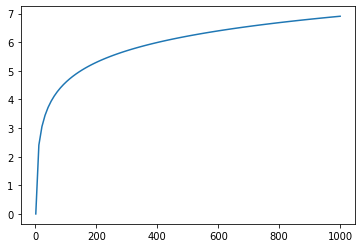

In [ ]:
# 5.3.1 Plot of log(count)
#       For low values of count() it 
#        tends to be zero and for large values
#         of count() it tries to suppress importance

import matplotlib.pyplot as plt
t = np.linspace(1, 1000, 100)
_=plt.plot(t, np.log(t))

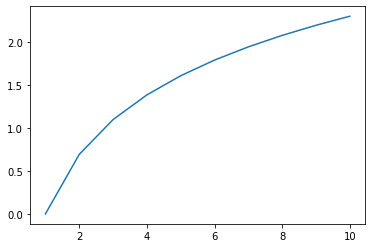

In [ ]:
# 5.3.2
t = np.linspace(1, 10, 10)
_=plt.plot(t, np.log(t))

In [ ]:
# 5.4 Rate calculation function
#     apply() calls this function and passes to it
#     just one group (or one dataframe subset)
#     So, 'x' is that group or DataFrame.
#     Therefore, x.sum(), is a scalar
#     so also x.count().

def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        # x.sum() is a scalar so also x.count() 
        probability = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return probability * conf


In [ ]:
# 5.5 Grouping and rate-calculations:

cols = ['app', 'channel']
grouped = train.groupby(cols)  
grouped['is_attributed']. \
            apply(rate_calculation). \
            reset_index().head()

,app,channel,is_attributed
0,0,101,0.053842
1,1,13,0.000000
2,1,17,0.000000
3,1,18,0.000000
4,1,24,0.000000


In [ ]:
# 5.5.1 Here are the full results
cols = ['app', 'channel']

# 5.6
new_feature_name = 'appchannelConfRate'

# 5.7
grouped['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                    #index=str,
                    columns={'is_attributed': new_feature_name}
                   ).head()

,app,channel,appchannelConfRate
0,0,101,0.053842
1,1,13,0.000000
2,1,17,0.000000
3,1,18,0.000000
4,1,24,0.000000


In [ ]:
# 5.8 Grouping and reindexing
cols = ['app', 'channel']
new_feature_name = 'appchannelConfRate'
grouped['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                    #index=str,
                    columns={'is_attributed': new_feature_name}
                   )[cols + [new_feature_name]]
                        

,app,channel,appchannelConfRate
0,0,101,0.053842
1,1,13,0.000000
2,1,17,0.000000
3,1,18,0.000000
4,1,24,0.000000
...,...,...,...
662,549,347,0.000000
663,556,347,0.000000
664,617,347,0.000000
665,633,101,0.000000


In [ ]:
# 5.8 Both grouping and merging 
#     Merging the group back into main data
#     And finally merging the above result 
#     in the train data

abc = train.merge(
                    grouped['is_attributed']. \
                    apply(rate_calculation). \
                    reset_index(). \
                         rename( 
                                #index=str,
                                columns={'is_attributed': new_feature_name}
                                )[cols + [new_feature_name]],
                         on=cols,
                         how='left'
                    )

abc.head(3)

##  Finally develop relationship of categorical features with target
We now use the above experiments to create new features. Create each new feature by multiplying `probability` with `confRate`. We define a full function to perform this. You may refer to Tables 2 and 3 above.

In [ ]:
# 6.0 Now the full function
#     for many columns

log_group_const = 100000

# 6.1 Our lists
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],    # 5
    
    # V2 Features #
    ###############
    ['app', 'channel'],    # name "app_channel" 
    ['app', 'os'],         # name: "app_os"
    ['app', 'device'],     # name: "app_device" 
    
    # V3 Features #
    ###############
    ['channel', 'os'],     # name: "channel_os"
    ['channel', 'device'], # name: "channel_device"
    ['os', 'device']       # name: "os_device"
]

# 6.2 Function to calculate probability/confRate calculations
def rate_calculation(x):
    """Calculate the attributed rate. Scale by confidence"""

    probability = x.sum() / float(x.count())
    conf = np.min([1, np.log(x.count()) / log_group_const])
    return probability * conf



In [ ]:

freqs = {}

# 6.3
for cols in ATTRIBUTION_CATEGORIES:
    
    # 6.3.1 New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # 6.3.2 Perform the groupby
    grouped = train.groupby(cols)   # For example on: ['app', 'channel']
    
    # 6.3.3 Group sizes: Size of each group in pandas Series    
    group_sizes = grouped.size()

    # 6.3.4 Normalizer that can be a hyperparameter
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    
    
    # 6.3.5 Perform the merge
    train = train.merge(
                         grouped['is_attributed']. \
                         apply(rate_calculation). \
                         reset_index(). \
                         rename( 
                                #index=str,
                                columns={'is_attributed': new_feature_name}
                                )[cols + [new_feature_name]],
                         on=cols,
                         how='left'
                         )    

In [ ]:
# 6.4
train.shape     # (999280, 23)  Earlier was # (999280, 12)
print()
print(train.columns) 
print()
train.head(3)

"""
[
       'ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second', 
       'ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate', 'channel_confRate',
       'app_channel_confRate', 'app_os_confRate', 'app_device_confRate',
       'channel_os_confRate', 'channel_device_confRate', 'os_device_confRate'
  ]
 """



(999189, 23)


Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second',
       'appchannelConfRate_x', 'appchannelConfRate_y', 'appchannelConfRate_x',
       'appchannelConfRate_y', 'appchannelConfRate_x', 'appchannelConfRate_y',
       'appchannelConfRate_x', 'appchannelConfRate_y', 'appchannelConfRate_x',
       'appchannelConfRate_y', 'appchannelConfRate'],
      dtype='object')



,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,appchannelConfRate_x,appchannelConfRate_y,appchannelConfRate_x,appchannelConfRate_y,appchannelConfRate_x,appchannelConfRate_y,appchannelConfRate_x,appchannelConfRate_y,appchannelConfRate_x,appchannelConfRate_y,appchannelConfRate
0,49305,3,1,25,379,2017-11-06 15:50:26,NaN,0,6,15,50,26,0.000000,0.000291,0.001818,0.000960,0.000140,0.000281,0.000000,0.000301,0.0,0.000140,0.000995
1,117898,2,2,36,205,2017-11-06 16:00:00,NaN,0,6,16,0,0,0.003349,0.000205,0.000255,0.004767,0.000148,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,60235,2,1,19,205,2017-11-06 16:00:01,NaN,0,6,16,0,1,0.000000,0.000205,0.001818,0.001865,0.000148,0.000000,0.000241,0.000215,0.0,0.000165,0.001891


"\n[\n       'ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',\n       'is_attributed', 'day', 'hour', 'minute', 'second', \n       'ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate', 'channel_confRate',\n       'app_channel_confRate', 'app_os_confRate', 'app_device_confRate',\n       'channel_os_confRate', 'channel_device_confRate', 'os_device_confRate'\n  ]\n "

##Relationship of features among themselves (Expts)
We first perform some experiments to to learn how to go about it in a concise manner.

### Some more experiments
We will now develop relationship among '*independent*' or '*explanatory*' categorical features. (See Table 1 above). To understand how it is done, we perform some simple experiments first.

In [32]:
# 7.0 Here is a sample of features. 
#     Please see that the three dict keys here 
#     correspond to three columns 
#     ('GroupBy','Operation', 'On') of Table 1.

PLAN_AGGREGATIONS = [
                      # V1 - GroupBy Features #
                      #########################    
                      # GroupBy [ip-app-channel], and calculate variance of 'day'
                      { 
                       'groupby': ['ip','app','channel'],
                       'select': 'day',
                       'agg': 'var' 
                       },
    
                      # GroupBy ip-app-os and calculate variance of 'hour'
                      {
                        'groupby': ['ip','app','os'],
                        'select': 'hour',
                        'agg': 'var'
                      }
                    ]

In [33]:
# 7.1 Make a copy of our data
#     (Our sample data is small. 
#       So this is possible for our expt here)

abc = train.copy()

# 7.2 First perform grouped sets
grouped = abc.groupby(['ip','app','channel'])

# 7.3 Then apply requisite aggregation on each grouped set
gred = grouped.agg({'day': 'var'})

# 7.4 Check. Our DataFrame has an Index with
#      three columns. It is Multiindex or 
#       hierarchical index
gred.head(3)

day
ip app channel     
6  9   134      NaN
   18  107      NaN
9  2   122      NaN

In [34]:
# 7.5 Reset index 
gred.reset_index().head()

,ip,app,channel,day
0,6,9,134,NaN
1,6,18,107,NaN
2,9,2,122,NaN
3,9,3,409,NaN
4,9,11,325,NaN


In [35]:
# 7.6 We can now re-write the above
#      in terms of dictionary key-values

abc = train.copy()
abc.head(2)
for i in PLAN_AGGREGATIONS:
  grouped = abc.groupby(i['groupby'])
  gred = grouped[i['select']].agg(i['agg'])
  gred = gred.reset_index()
  print(gred.head(3)) 

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,191894,3,1,18,379,2017-11-06 15:29:16,NaN,0,6,15,29,16
1,22333,3,1,19,379,2017-11-06 15:48:50,NaN,0,6,15,48,50


   ip  app  channel  day
0   6    9      134  NaN
1   6   18      107  NaN
2   9    2      122  NaN
   ip  app  os  hour
0   6    9   9   NaN
1   6   18  13   NaN
2   9    2   8   NaN


In [36]:
# 7.7 We can now re-write the above
#      in terms of dictionary key-values
abc = train.copy()
print(abc.shape)
for i in PLAN_AGGREGATIONS:
  # 7.7.1
  grouped = abc.groupby(i['groupby'])
  # 7.7.2
  gred = grouped[i['select']].agg(i['agg'])
  # 7.7.3
  gred = gred.reset_index().rename(columns = {i['select'] : "_".join(i['groupby']) +"_" +i['select'] + "_" +i['agg']} )
  # 7.7.4
  print(gred.head(3)) 
  # 7.7.5
  abc = abc.merge(gred)
  # 7.7.6
  print(abc.head(2))
  print(abc.shape)

(399520, 12)
   ip  app  channel  ip_app_channel_day_var
0   6    9      134                     NaN
1   6   18      107                     NaN
2   9    2      122                     NaN
       ip  app  device  os  ...  hour minute second  ip_app_channel_day_var
0  191894    3       1  18  ...    15     29     16                     NaN
1   22333    3       1  19  ...    15     48     50                     NaN

[2 rows x 13 columns]
(399520, 13)
   ip  app  os  ip_app_os_hour_var
0   6    9   9                 NaN
1   6   18  13                 NaN
2   9    2   8                 NaN
       ip  app  device  ...  second  ip_app_channel_day_var ip_app_os_hour_var
0  191894    3       1  ...      16                     NaN                2.0
1  191894    3       1  ...      58                     NaN                2.0

[2 rows x 14 columns]
(399520, 14)


In [ ]:
# 8.0 Apply now all the groupby transformations
abc = train.copy()

for spec in PLAN_AGGREGATIONS:
    
    # 8.1 What aggregation operator we're applying?
    agg_name = spec['agg']
    
    # 8.2 What would be the name of new feature
    new_feature = '{}_{}_{}'. \
                   format( \
                          '_'.join(spec['groupby']),
                          agg_name, 
                          spec['select']
                          )
   
    # 8.3 Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # 8.4 Perform the groupby
    gp = abc[all_features]. \
         groupby(spec['groupby'])[spec['select']]. \
         agg(spec['agg']). \
         reset_index(). \
         rename(columns={spec['select']: new_feature})
        
    # 8.5 Merge back to X_total
    abc = abc.merge(gp, on=spec['groupby'], how='left')
        
     # 8.6 Clear memory
    del gp
    gc.collect()
abc.head()    

##Perform final feature generation
We now use the above experiments to write our final function and perform feature generation (among explanatory features).

###First develop grouping plan
Plan describes:<br> i) which features will be grouped,<br> ii) which feature will be summarised, and<br> iii) what kind of summary (count, var etc)

In [ ]:
 # 9.0 Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # 9.1 V1 - GroupBy Features #
    #########################    
    # 9.2 Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # 9.2.1 Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # 9.2.2 Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # 9.2.3 Count of channel, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # 9.2.4 Count of channel, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # 9.2.5 Count of channel, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # 9.2.6 Count of channel, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # 9.2.7 Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # 10.0 V2 - GroupBy Features #
    #########################
    # 10.1 Average clicks on app by distinct users; is it an app they return to?
    #{'groupby': ['app'], 
    # 'select': 'ip', 
    # 'agg': lambda x: float(len(x)) / len(x.unique()), 
    # 'agg_name': 'AvgViewPerDistinct'
    #},
    # 10.2 How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # 10.3 V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    #{'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    #{'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    #{'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
  ]

###Next, use the plan 
Write now a for-loop to go over the plan, one at a time. In the for-loop,as and when new-feature is created, go on merging this new-feature with the train data after giving appropriate name (or a descriptive name) to the new-feature

In [ ]:
# 11.0 Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # 11.1 Name of the aggregation we're applying
    agg_name = spec['agg']
    
    # 11.2 Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # 11.3 Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # 11.4 Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # 11.5 Perform the groupby
    gp = train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(   \
                #index=str, \
                columns={spec['select']: new_feature} \
               )
    # 11.6    
    train = train.merge(gp, on=spec['groupby'], how='left')
        
     # 11.7 Clear memory
    del gp
    gc.collect()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var


69

Grouping by ['ip', 'app', 'os'], and aggregating hour with var


0

Grouping by ['ip', 'day', 'channel'], and aggregating hour with var


0

Grouping by ['ip', 'day', 'hour'], and aggregating channel with count


0

Grouping by ['ip', 'app'], and aggregating channel with count


0

Grouping by ['ip', 'app', 'os'], and aggregating channel with count


0

Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count


0

Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean


0

Grouping by ['app'], and aggregating channel with count


0

Grouping by ['channel'], and aggregating app with count


0

Grouping by ['ip'], and aggregating channel with nunique


0

Grouping by ['ip'], and aggregating app with nunique


0

Grouping by ['ip', 'day'], and aggregating hour with nunique


0

Grouping by ['ip', 'app'], and aggregating os with nunique


0

Grouping by ['ip'], and aggregating device with nunique


0

Grouping by ['app'], and aggregating channel with nunique


0

Grouping by ['ip', 'device', 'os'], and aggregating app with nunique


0

Grouping by ['ip', 'day', 'channel'], and aggregating hour with var


0

##Save your data
As the final data will have very large number of features and you do not want to go over it again, save to Google drive for later use.

In [ ]:
#####################